<p style="text-align:center">
  <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
  <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"/>
  </a>
</p>


# **Course Rating Prediction using Neural Networks (CF ANN)**

Estimated time needed: **60–90** minutes

In previous labs, we used explicit user/item features and NMF to uncover latent factors. Here, we'll build a neural collaborative filtering model that learns user/item embeddings directly from interactions and predicts ratings. We will:

- Train a **baseline dot-product** embedding model (`RecommenderNet`).
- **Complete the optional part**: Train a stronger **Two-Tower MLP** model on concatenated embeddings.
- Evaluate both, save artifacts to your project tree, and export learned embeddings.


## Objectives

After completing this lab you will be able to:
- Use `tensorflow` to train neural recommenders (embeddings + dot-product / MLP)
- Evaluate with RMSE (scaled and original rating scale)
- Save models, plots, metrics, and embedding tables to your repo structure


----
## Prepare and setup lab environment

Install TensorFlow 2.7 if needed (you can skip if your env already has TF≥2.7).

In [3]:
!python -c "import tensorflow as _; print('TF OK:', _..__version__)" || pip install -q tensorflow==2.7.0

  File "<string>", line 1
    import tensorflow as _; print('TF OK:', _..__version__)
                                              ^
SyntaxError: invalid syntax
ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.7.0


Import libraries and set seeds.

In [4]:
import os, sys, json
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
PY_SEED = 123
np.random.seed(PY_SEED)
tf.random.set_seed(PY_SEED)

print('Python:', sys.version.split()[0])
print('TF:', tf.__version__)

Python: 3.12.11
TF: 2.20.0


### Project paths

In [5]:
# Detect project root (repo root has 'data', 'models' etc.)
CWD = Path.cwd().resolve()
if CWD.name == 'notebooks' and (CWD.parent / 'data').exists():
    PROJECT_ROOT = CWD.parent
elif (CWD / 'data').exists():
    PROJECT_ROOT = CWD
elif (CWD.parent / 'data').exists():
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD  

DATA_DIR = PROJECT_ROOT / 'data'
EXTERNAL_DIR = DATA_DIR / 'external'
PROCESSED_DIR = DATA_DIR / 'processed'
INTERIM_DIR = DATA_DIR / 'interim'
MODELS_DIR = PROJECT_ROOT / 'models'
REPORTS_FIG_DIR = PROJECT_ROOT / 'reports' / 'figures'
LOGS_DIR = PROJECT_ROOT / 'logs'

for d in [EXTERNAL_DIR, PROCESSED_DIR, INTERIM_DIR, MODELS_DIR, REPORTS_FIG_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('PROJECT_ROOT =', PROJECT_ROOT)
print('Data exists:', (EXTERNAL_DIR/'course_ratings.csv').exists())

PROJECT_ROOT = /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone
Data exists: True


### Load and process rating dataset

We prefer your local dataset at `data/external/course_ratings.csv`. If missing, we fallback to the hosted file used in other labs.

In [6]:
local_csv = EXTERNAL_DIR / 'course_ratings.csv'
fallback_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv'

if local_csv.exists():
    rating_df = pd.read_csv(local_csv)
else:
    rating_df = pd.read_csv(fallback_url)

assert {'user','item','rating'}.issubset(rating_df.columns), 'Input must have user,item,rating columns'
rating_df = rating_df[['user','item','rating']].copy()
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


Compute unique counts (define the embedding lookup sizes).

In [7]:
num_users = rating_df['user'].nunique()
num_items = rating_df['item'].nunique()
min_rating = int(rating_df['rating'].min())
max_rating = int(rating_df['rating'].max())
print(f"Users: {num_users} | Items: {num_items} | rating range: [{min_rating}, {max_rating}]")

Users: 33901 | Items: 126 | rating range: [3, 5]


### Baseline Recommender (dot-product embeddings)
The model learns user & item embeddings, takes their dot-product (plus per-entity biases), and uses a sigmoid to map to [0,1] because we will scale ratings to 0–1.

In [8]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        super().__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            input_dim=num_users, output_dim=embedding_size,
            name='user_embedding_layer', embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.item_embedding = layers.Embedding(
            input_dim=num_items, output_dim=embedding_size,
            name='item_embedding_layer', embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(input_dim=num_users, output_dim=1, name='user_bias')
        self.item_bias = layers.Embedding(input_dim=num_items, output_dim=1, name='item_bias')

    def call(self, inputs):  # inputs: (batch, 2) [user_idx, item_idx]
        u = inputs[:, 0]
        i = inputs[:, 1]
        u_vec = self.user_embedding(u)    # (batch, d)
        i_vec = self.item_embedding(i)    # (batch, d)
        u_b = self.user_bias(u)           # (batch, 1)
        i_b = self.item_bias(i)           # (batch, 1)
        dot = tf.reduce_sum(u_vec * i_vec, axis=1, keepdims=True)
        x = dot + u_b + i_b
        return tf.nn.sigmoid(x)           # scaled label in [0,1]


### Encode IDs → indices and split train/val/test with rating scaling

In [9]:
def process_dataset(raw_df):
    df = raw_df.copy()
    users = df['user'].unique().tolist()
    items = df['item'].unique().tolist()
    uid2idx = {u:i for i,u in enumerate(users)}
    iid2idx = {it:i for i,it in enumerate(items)}
    idx2uid = {i:u for u,i in uid2idx.items()}
    idx2iid = {i:it for it,i in iid2idx.items()}
    df['user'] = df['user'].map(uid2idx)
    df['item'] = df['item'].map(iid2idx)
    df['rating'] = df['rating'].astype(int)
    return df, idx2uid, idx2iid

def make_splits(encoded_df, scale=True, seed=PY_SEED):
    min_r = int(encoded_df['rating'].min())
    max_r = int(encoded_df['rating'].max())
    df = encoded_df.sample(frac=1, random_state=seed).reset_index(drop=True)
    X = df[['user','item']].values.astype('int32')
    if scale:
        y = ((df['rating'] - min_r) / (max_r - min_r)).values.astype('float32')
    else:
        y = df['rating'].values.astype('float32')
    n = len(df)
    n_tr, n_val = int(0.8*n), int(0.9*n)
    x_train, y_train = X[:n_tr], y[:n_tr]
    x_val, y_val = X[n_tr:n_val], y[n_tr:n_val]
    x_test, y_test = X[n_val:], y[n_val:]
    return (x_train, y_train), (x_val, y_val), (x_test, y_test), (min_r, max_r)

encoded_df, idx2uid, idx2iid = process_dataset(rating_df)
(x_train, y_train), (x_val, y_val), (x_test, y_test), (MIN_R, MAX_R) = make_splits(encoded_df, scale=True)
print('Shapes:', x_train.shape, x_val.shape, x_test.shape, '| rating range:', (MIN_R, MAX_R))

Shapes: (186644, 2) (23331, 2) (23331, 2) | rating range: (3, 5)


### Train baseline model

In [10]:
baseline = RecommenderNet(num_users=num_users, num_items=num_items, embedding_size=16)
baseline.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)
cb = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
hist_base = baseline.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=cb,
    verbose=1
)

# Save model
base_model_path = MODELS_DIR / 'RecommenderNet_baseline.keras'
baseline.save(base_model_path)
print('Saved baseline model ->', base_model_path)

Epoch 1/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1669 - rmse: 0.4082 - val_loss: 0.1678 - val_rmse: 0.4090
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1522 - rmse: 0.3883 - val_loss: 0.1729 - val_rmse: 0.4130
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1072 - rmse: 0.3213 - val_loss: 0.1875 - val_rmse: 0.4266
Saved baseline model -> /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/models/RecommenderNet_baseline.keras


### Evaluate (scaled + original rating scale) and plot curves

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
{'baseline_test_mse': 0.16676464676856995, 'baseline_test_rmse_scaled': 0.4077935218811035, 'baseline_test_rmse_orig': 0.8155872225761414}


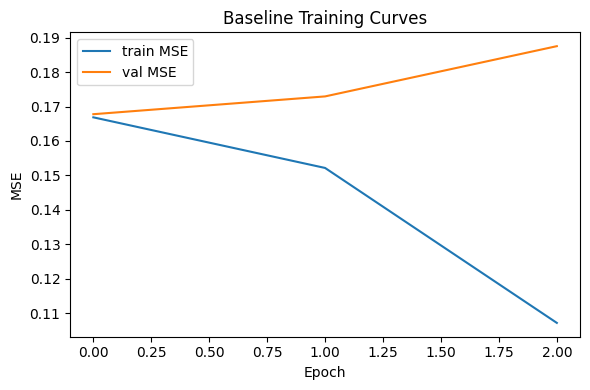

Saved figure -> /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/reports/figures/baseline_training_curves.png
Metrics appended -> /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/data/processed/recommender_eval.csv


/var/folders/q0/bm9058_95z16l6j28pkf1z580000gn/T/ipykernel_65365/121277191.py:26: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.utcnow().isoformat(),


In [11]:
def inv_scale(y):
    return y * (MAX_R - MIN_R) + MIN_R

# Evaluate on test
test_mse, test_rmse = baseline.evaluate(x_test, y_test, verbose=0)
yhat_scaled = baseline.predict(x_test, batch_size=1024).ravel()
y_scaled = y_test
yhat_orig = np.clip(inv_scale(yhat_scaled), MIN_R, MAX_R)
y_orig = inv_scale(y_scaled)
rmse_orig = float(np.sqrt(np.mean((yhat_orig - y_orig)**2)))

print({'baseline_test_mse': float(test_mse), 'baseline_test_rmse_scaled': float(test_rmse), 'baseline_test_rmse_orig': rmse_orig})

# Plot
plt.figure(figsize=(6,4))
plt.plot(hist_base.history['loss'], label='train MSE')
plt.plot(hist_base.history['val_loss'], label='val MSE')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Baseline Training Curves'); plt.legend(); plt.tight_layout()
fig_path_base = REPORTS_FIG_DIR / 'baseline_training_curves.png'
plt.savefig(fig_path_base, dpi=150)
plt.show()
print('Saved figure ->', fig_path_base)

# Log & save metrics
metrics_row = {
    'timestamp': datetime.utcnow().isoformat(),
    'model': 'RecommenderNet_baseline',
    'embedding_size': 16,
    'test_mse_scaled': float(test_mse),
    'test_rmse_scaled': float(test_rmse),
    'test_rmse_original': rmse_orig
}
metrics_csv = PROCESSED_DIR / 'recommender_eval.csv'
pd.DataFrame([metrics_row]).to_csv(metrics_csv, mode='a', index=False, header=not metrics_csv.exists())
with open(LOGS_DIR / 'training_log.txt', 'a') as f:
    f.write(json.dumps(metrics_row) + '\n')
print('Metrics appended ->', metrics_csv)

### Export learned embeddings (users & items)

In [12]:
U = baseline.get_layer('user_embedding_layer').get_weights()[0]
I = baseline.get_layer('item_embedding_layer').get_weights()[0]

user_df = pd.DataFrame(U)
user_df.insert(0, 'user_id', user_df.index.map(idx2uid))
item_df = pd.DataFrame(I)
item_df.insert(0, 'item_id', item_df.index.map(idx2iid))

user_emb_path = PROCESSED_DIR / 'user_embeddings_baseline.csv'
item_emb_path = PROCESSED_DIR / 'item_embeddings_baseline.csv'
user_df.to_csv(user_emb_path, index=False)
item_df.to_csv(item_emb_path, index=False)
print('Saved embeddings ->', user_emb_path, '|', item_emb_path)

Saved embeddings -> /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/data/processed/user_embeddings_baseline.csv | /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/data/processed/item_embeddings_baseline.csv


----
## (Optional, now completed) Two-Tower MLP Recommender
We concatenate user & item embeddings and feed them to an MLP with dropout and layer norm. This can capture richer interactions than a pure dot-product.

In [13]:
class TwoTowerMLP(keras.Model):
    def __init__(self, num_users, num_items, embedding_size=32, hidden=(64, 32), dropout=0.2, **kwargs):
        super().__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal',
                                              embeddings_regularizer=keras.regularizers.l2(1e-6), name='user_emb')
        self.item_embedding = layers.Embedding(num_items, embedding_size, embeddings_initializer='he_normal',
                                              embeddings_regularizer=keras.regularizers.l2(1e-6), name='item_emb')
        self.user_bias = layers.Embedding(num_users, 1, name='user_bias')
        self.item_bias = layers.Embedding(num_items, 1, name='item_bias')
        self.concat = layers.Concatenate()
        self.norm = layers.LayerNormalization()
        self.hidden = [layers.Dense(h, activation='relu') for h in hidden]
        self.drop = layers.Dropout(dropout)
        self.out = layers.Dense(1, activation='sigmoid')  # scaled rating

    def call(self, inputs, training=False):
        u = inputs[:,0]; i = inputs[:,1]
        u_vec = self.user_embedding(u)
        i_vec = self.item_embedding(i)
        u_b = self.user_bias(u); i_b = self.item_bias(i)
        z = self.concat([u_vec, i_vec])
        z = self.norm(z)
        for dense in self.hidden:
            z = dense(z)
            z = self.drop(z, training=training)
        x = self.out(z)
        return x + u_b + i_b  # small bias shift


### Train Two-Tower model

In [14]:
tt = TwoTowerMLP(num_users=num_users, num_items=num_items, embedding_size=32, hidden=(128, 64), dropout=0.25)
tt.compile(optimizer=keras.optimizers.Adam(1e-3),
           loss=keras.losses.MeanSquaredError(),
           metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])
cb2 = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
hist_tt = tt.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=cb2,
    verbose=1
)
tt_path = MODELS_DIR / 'TwoTowerMLP_v1.keras'
tt.save(tt_path)
print('Saved TwoTower model ->', tt_path)

Epoch 1/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1697 - rmse: 0.4114 - val_loss: 0.1700 - val_rmse: 0.4116
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1596 - rmse: 0.3978 - val_loss: 0.1746 - val_rmse: 0.4155
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1271 - rmse: 0.3527 - val_loss: 0.1856 - val_rmse: 0.4268
Saved TwoTower model -> /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/models/TwoTowerMLP_v1.keras


### Evaluate Two-Tower and compare

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
{'twotower_test_mse': 0.16912125051021576, 'twotower_test_rmse_scaled': 0.4104522466659546, 'twotower_test_rmse_orig': 0.820904552936554}


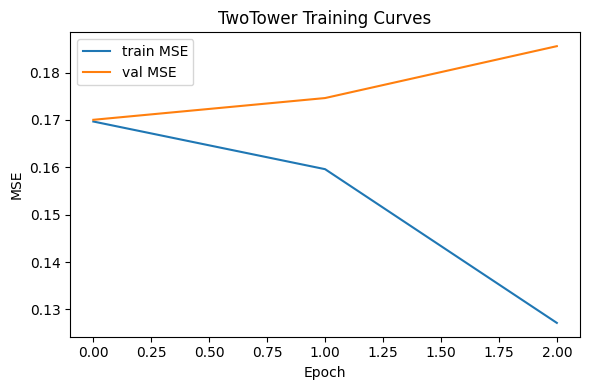

Saved figure -> /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/reports/figures/twotower_training_curves.png


/var/folders/q0/bm9058_95z16l6j28pkf1z580000gn/T/ipykernel_65365/2574413240.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.utcnow().isoformat(),


In [15]:
tt_mse, tt_rmse = tt.evaluate(x_test, y_test, verbose=0)
tt_pred_scaled = tt.predict(x_test, batch_size=1024).ravel()
tt_pred_orig = np.clip(inv_scale(tt_pred_scaled), MIN_R, MAX_R)
tt_rmse_orig = float(np.sqrt(np.mean((tt_pred_orig - inv_scale(y_test))**2)))
print({'twotower_test_mse': float(tt_mse), 'twotower_test_rmse_scaled': float(tt_rmse), 'twotower_test_rmse_orig': tt_rmse_orig})

# Plot curves
plt.figure(figsize=(6,4))
plt.plot(hist_tt.history['loss'], label='train MSE')
plt.plot(hist_tt.history['val_loss'], label='val MSE')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('TwoTower Training Curves'); plt.legend(); plt.tight_layout()
fig_path_tt = REPORTS_FIG_DIR / 'twotower_training_curves.png'
plt.savefig(fig_path_tt, dpi=150)
plt.show()
print('Saved figure ->', fig_path_tt)

# Append metrics
metrics_row_tt = {
    'timestamp': datetime.utcnow().isoformat(),
    'model': 'TwoTowerMLP_v1',
    'embedding_size': 32,
    'test_mse_scaled': float(tt_mse),
    'test_rmse_scaled': float(tt_rmse),
    'test_rmse_original': tt_rmse_orig
}
pd.DataFrame([metrics_row_tt]).to_csv(PROCESSED_DIR / 'recommender_eval.csv', mode='a', index=False, header=False)
with open(LOGS_DIR / 'training_log.txt', 'a') as f:
    f.write(json.dumps(metrics_row_tt) + '\n')

### (Bonus) Generate sample recommendations for one user and save

In [16]:
def topk_for_user(model, user_idx, known_item_idx_set, k=10, batch=2048):
    all_items = np.arange(num_items, dtype='int32')
    mask = np.array([it not in known_item_idx_set for it in all_items])
    cand_items = all_items[mask]
    user_col = np.full_like(cand_items, user_idx)
    X = np.stack([user_col, cand_items], axis=1)
    preds = model.predict(X, batch_size=batch, verbose=0).ravel()
    order = np.argsort(-preds)[:k]
    return cand_items[order], preds[order]

# Pick a user from test split (by encoded index)
u0 = int(x_test[0,0])
user_rows = encoded_df[encoded_df['user']==u0]
known_items = set(user_rows['item'].tolist())
rec_items, rec_scores = topk_for_user(tt, u0, known_items, k=10)
rec_df = pd.DataFrame({
    'user_id': idx2uid[u0],
    'item_id': [idx2iid[i] for i in rec_items],
    'score': rec_scores
})
rec_path = PROCESSED_DIR / 'sample_recs.csv'
rec_df.to_csv(rec_path, index=False)
rec_df.head(10)

,user_id,item_id,score
0,211093,BD0141EN,0.567619
1,211093,RP0105EN,0.563063
2,211093,BD0151EN,0.554654
3,211093,GPXX0T0FEN,0.548297
4,211093,SC0105EN,0.538768
5,211093,PA0107EN,0.534622
6,211093,BD0145EN,0.534576
7,211093,ML0120ENv3,0.532312
8,211093,CB0103EN,0.528356
9,211093,DV0151EN,0.527181


## Summary

- Trained **baseline dot-product** and **Two-Tower MLP** recommenders.
- Saved artifacts:
  - Models → `models/RecommenderNet_baseline.keras`, `models/TwoTowerMLP_v1.keras`
  - Training curves → `reports/figures/*.png`
  - Metrics → `data/processed/recommender_eval.csv`
  - Embeddings → `data/processed/user_embeddings_baseline.csv`, `data/processed/item_embeddings_baseline.csv`
  - Sample recommendations → `data/processed/sample_recs.csv`
- Logged runs to `logs/training_log.txt`.

## Authors
[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)

Copyright © 2021–2025 IBM Corporation. All rights reserved.